# GAN (생성적 적대 신경망 : Generative adversarial network)
- 생성기와 판별기라는 신경망 모델이 적대하도록 만들어져있다. 
- 판별기의 목적 : 훈련 데이터 셋을 진짜라고 예측하게끔 훈련, 생성기에서 생성된 이미지를 가짜라고 예측하게끔 훈련. 
- 생성기의 목적 :판별기가 분류할 이미지를 생성하는 역할을 하며, 만든 이미지에 대해 판별기의 결과가 1.0이 되도록(판별기를 속일 수 있는 데이터를 만드는 것) 하는 것. 

## 판별기 업데이트:
- 1단계 : 판별기에 실제 데이터를 보여주고 1.0이라는 값이어야 한다고 알려준다

- 2단계 : 판별기에 생성기로부터 만들어진 가짜 데이터를 보여주고 0.0 이어야한다고 알려준다

## 생성기 업데이트
- 3단계 : 판별기에 생성기의 결과를 보여주고 생성기에 결과가 1.0 이어야 한다고 알려준다 

# 6. Simple 1010 patterns

## 실제 데이터 소스

In [17]:
import torch
import torch.nn as nn
import pandas
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
# 실제 데이터에 대하여 1010 패턴을 반환하는 함수에 약간의 임의성을 추가하여 함수를 조금 더 실제 상화와 가깝게 만들어보자. 
def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8,1.0),
        random.uniform(0.0,0.2),
        random.uniform(0.8,1.0),
        random.uniform(0.0,0.2)])
    return real_data

generate_real()
        

tensor([0.8657, 0.0966, 0.8763, 0.0252])

## 판별기 만들기 

In [3]:
class Discriminator (nn.Module): # nn.Module 을 상속받아 신경망 클래스를 만들어보자 
    def __init__(self):
        #파이토치 부모 클래스 초기화
        super().__init__()
        
        #신경망 레이어 정의
        self.model = nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
        )
        
        #손실함수 설정
        self.loss_function = nn.MSELoss()
        
        #옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(),lr=0.1)
        
        #진행 측정을 위한 변수 초기화
        self.counter =0 ;
        self.progress =[]
        
        pass
    
    def forward(self,inputs):
        #모델실행
        return self.model(inputs)
    def train(self, inputs,targets):
        #신경망 출력 계산
        outputs = self.forward(inputs)
        
        #손실계산
        loss = self.loss_function(outputs,targets)
        
        #카운터를 증가시키고 10회마다 오차 저장
        self.counter+=1 ;
        if (self.counter %10==0):
            self.progress.append(loss.item())
            pass
        if (self.counter %10000==0):
            print("counter = ",self.counter)
            pass
        
        #기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad() #기울기 초기화
        loss.backward() #역전파 실행
        self.optimiser.step() #가중치 갱신
        
    def plot_progress(self):
        df= pandas.DataFrame(self.progress , columns=['loss'])
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
        pass

        
        

## 판별기 테스트 하기 


In [4]:
#임의의 노이즈 패턴을 반환하는 함수 

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

generate_random(4)

tensor([0.9538, 0.6414, 0.8617, 0.2894])

### 훈련 반복문 
- 1010 패턴의 데이터는 목표출력을 1.0
- 임의의 노이즈 데이터는 목표출력을 0.0 으로 훈련!!!

In [5]:
D= Discriminator()

for i in range(10000):
    #실제 데이터 
    D.train(generate_real(),torch.FloatTensor([1.0]))
    
    #생성된 데이터 
    D.train(generate_random(4),torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


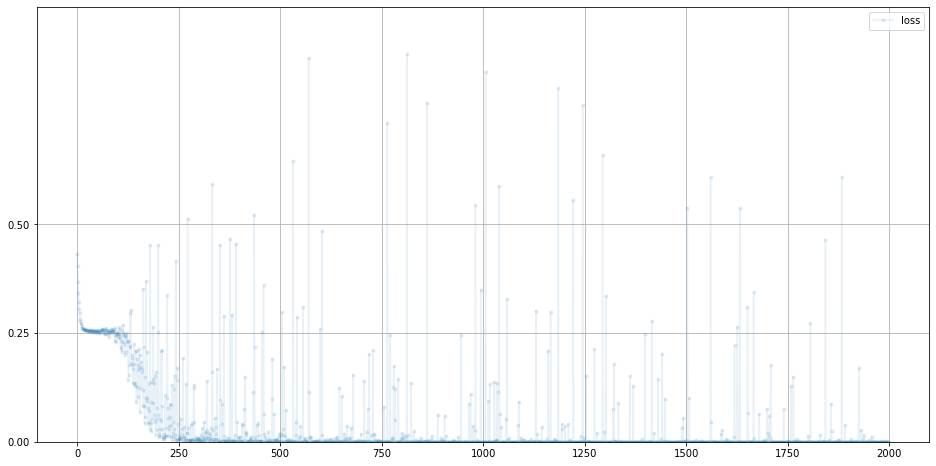

In [6]:
D.plot_progress()

In [7]:
# 훈련된 판별기에 어떤 패턴을 넣어서 테스트. 

print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.9784053564071655
0.001538945478387177


## 생성기 만들기 

In [8]:
class Generator (nn.Module): # nn.Module 을 상속받아 신경망 클래스를 만들어보자 
    def __init__(self):
        #파이토치 부모 클래스 초기화
        super().__init__()
        
        #신경망 레이어 정의 # 판별기와는 반대
        self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
        )
        
        #손실함수 설정
        # 안해도 된다. 손실함수는 오직 판별기의 결과에만 적용이 된다. 생겅기는 판별기로 부터 흘러온 기울기 오차를 통해 업데이트됨.
        
        
        #옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(),lr=0.1)
        
        #진행 측정을 위한 변수 초기화
        self.counter =0 ;
        self.progress =[]
        
        pass
    
    def forward(self,inputs):
        #모델실행
        return self.model(inputs)
    
    '''
    판별기를 훈련할 떄는 어떤 결과가 정답이 되어야 하는지 명확하게 알지만 생서익의 경우는 아님
    판별기의 결과로 계산된 손실의 역전파 값이 있다.
    결과적으로, 생성기를 훈련 시킬 때는 판별기가 필요합니다 . 판별기를 생성기의 train 함수에 넘겨주는 방식이다. 
    '''
    
    def train(self,D, inputs,targets):
        #신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기로 전달
        d_output =D.forward(g_output)
        
        #손실계산
        loss = D.loss_function(d_output,targets)
        
        #카운터를 증가시키고 10회마다 오차 저장
        self.counter+=1 ;
        if (self.counter %10==0):
            self.progress.append(loss.item())
            pass
    
        #기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad() #기울기 초기화
        loss.backward() #역전파 실행
        self.optimiser.step() #가중치 갱신
        
    def plot_progress(self):
        df= pandas.DataFrame(self.progress , columns=['loss'])
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
        pass

        
        

In [9]:
# 훈련전 생성기 결과 확인하기
G= Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5959, 0.4995, 0.6314, 0.4617], grad_fn=<SigmoidBackward>)

## GAN 훈련하기

In [21]:
%%time
#판별기 ,생성기 생성
D= Discriminator()
G= Generator()

image_list=[]
# 판별기,생성기 훈련
for i in range(10000):
    # 1단계 : 참에 대한 판결기 훈련 (실제 데이터에 대해서 훈련)
    D.train(generate_real(),torch.FloatTensor([1.0]))
    
    '''
    #2단계 :거짓에 대해 판별기 훈련 - 생성기에서 비롯된 패턴을 통해 학습
    - G의 기울기가 계산되지 않도록 detach() 함수를 이용 -생성기의 출력에 적용되어 계산 그래프에서 생성기를 떼어내는 역할을 함.
    현재 판별기 훈련중이므로 생성기의 기울기를 계산할 이유가 없음 
    '''
    D.train(G.forward(torch.FloatTensor([0.5])).detach(),torch.FloatTensor([0.0]))
    
    # 3단계 : 생성기 훈련
    G.train(D,torch.FloatTensor([0.5]),torch.FloatTensor([1.0]))
    
    # 추가적으로 , 1010 패턴이 어떤 식으로 훈련을 거치며 변화하는지 시각화해보자 
    #매 1000회 이미지를 저장    
    if ( i % 1000 ==0):
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

    pass
    

counter =  10000
counter =  20000
Wall time: 10.4 s


'\n판별기가 실제 데이터와 조작된 데이터를 잘 판별하지 못하는 결과를 내놓는 다면 , 그결과는 0.5라는 결과를 내놓을 것이다.\n현재 평균 제곱오차를 이용했기 때문에 0.5를 제곱한 0.25가 손실로 나오는 것이다. \n'

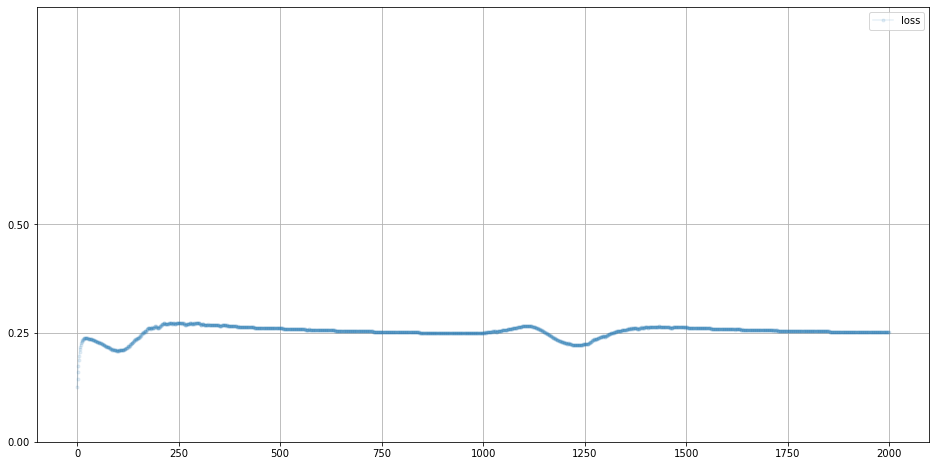

In [22]:
D.plot_progress()

'''
판별기가 실제 데이터와 조작된 데이터를 잘 판별하지 못하는 결과를 내놓는 다면 , 그결과는 0.5라는 결과를 내놓을 것이다.
현재 평균 제곱오차를 이용했기 때문에 0.5를 제곱한 0.25가 손실로 나오는 것이다. 
'''

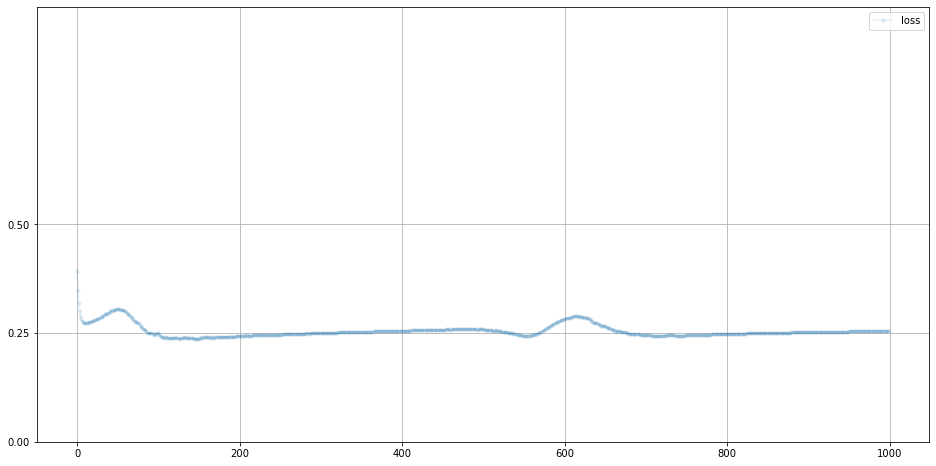

In [23]:
G.plot_progress()

In [24]:
# 이제 생성기가 만들어낸 데이터를 보고 어떤 패턴을 만들어 냈는지 확인해보자! 우리가 처음으로 생성해본 데이터다

G.forward(torch.FloatTensor([0.5]))

tensor([0.9426, 0.0360, 0.9625, 0.0440], grad_fn=<SigmoidBackward>)

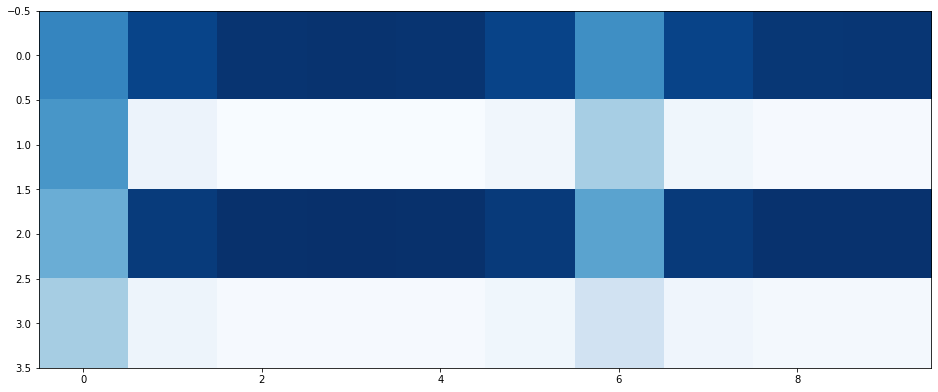

In [25]:
plt.figure(figsize=(16,8))
plt.imshow(np.array(image_list).T,interpolation='none',cmap='Blues')

In [26]:
image_list

[array([0.6631048 , 0.60045546, 0.50092417, 0.3567667 ], dtype=float32),
 array([0.8999098 , 0.076246  , 0.9339972 , 0.06823883], dtype=float32),
 array([0.95908356, 0.02566074, 0.9735309 , 0.03285396], dtype=float32),
 array([0.9658162 , 0.02196895, 0.9774121 , 0.0298478 ], dtype=float32),
 array([0.95885277, 0.0248969 , 0.97313595, 0.03301038], dtype=float32),
 array([0.9039092 , 0.05227917, 0.9379233 , 0.05861894], dtype=float32),
 array([0.6298331 , 0.35381606, 0.5448867 , 0.20335554], dtype=float32),
 array([0.9045673 , 0.05561118, 0.9375059 , 0.06155508], dtype=float32),
 array([0.95018095, 0.03285947, 0.96702766, 0.04065178], dtype=float32),
 array([0.9549045 , 0.03072119, 0.9699138 , 0.03854786], dtype=float32)]